# Tangles-CNN classifier validation script

In [1]:
# Load dependencies
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import json
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
# import sklearn.metrics
import pandas as pd
from PIL import Image

# Import modified wildcat
#sys.path.append("../tangle-cnn-prod/")
#sys.path.append("../tangle-cnn-prod/wildcat_pytorch")
#from wildcat_pytorch.picsl_wildcat import util, models

# Import modified wildcat
sys.path.append("../tangle-cnn-prod/")
sys.path.append("../tangle-cnn-prod/wildcat_pytorch")
from unet_wildcat_gmm import *
from picsl_wildcat import util, models

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.9.0
Torchvision Version:  0.10.0a0
CUDA status:  True
CUDA memory max alloc:        0 MB


## Validation Setup

In [2]:
# Set the experiment directory
# exp_dir = "/home/me/data/patches/exp01"
exp_dir = "/data/pauly2/wildcat/data/thon2019/exp02_multiclass"

# Load the manifest file, which has the bounding box sizes 
manifest_file = "/data/pauly2/wildcat/data/thon2019/manifest_2023.csv"

## Load Models

In [3]:
# Helper functions
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [4]:
# Set main directories
data_dir = os.path.join(exp_dir, "patches")
model_dir = os.path.join(exp_dir, "models_boxexp")

# Load model configuration from config.json
with open(os.path.join(model_dir, 'config.json'), 'r') as jfile:
    config = json.load(jfile)

# Set global properties
num_classes=config['num_classes']
cnames = {v:k for k,v in config['class_to_idx'].items() }
input_size=config['wildcat_upsample']['input_size']
batch_size=min(config['wildcat_upsample']['batch_size'], 32)

# Training and validation dataloaders
manifest = pd.read_csv(manifest_file) if config['wildcat_upsample']['bounding_box'] is True else None

# Create a data loader
dt = transforms.Compose([
    transforms.CenterCrop(input_size),
    util.NormalizeRGB([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Custom dataset object that generates masks from bounding boxes if needed
ds = util.ImageFolderWithBBox(os.path.join(data_dir, "test"), manifest, dt, 
                              config['wildcat_upsample']['bounding_box_min_size'])

# Data loader
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
# Create the wrapped model
model_ft=models.resnet50_wildcat_upsample(
    config['num_classes'], 
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

# Load the state dict of the wrapped model
model_ft.load_state_dict(
    torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))

# Wrap the model as a bounding box model
model_bb = models.BoundingBoxWildCatModel(model_ft)

# Send model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_bb.eval()
model_bb = model_bb.to(device)

Sending loaded model to device:  cuda


## Run model on random batch

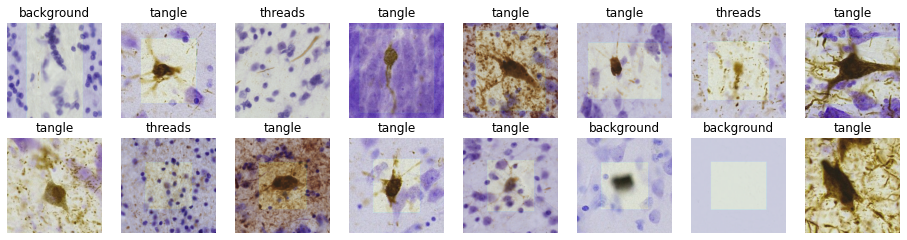

In [6]:
# Read a batch of data
img,label=next(iter(dl))
plt.figure(figsize=(16,6))
util.show_patches_with_masks(img, label, cnames, 8, 0.1, 2)

In [7]:
# Evaluate model on this batch
img_d = img.to(device)
label_d = label.to(device)
with torch.no_grad():
    outputs = model_bb(img_d)
_, preds = torch.max(outputs, 1)
(preds.cpu(),label)

/home/pauly2/.conda/envs/be537/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-19kunu9c/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(tensor([0, 2, 3, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2]),
 tensor([0, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2]))

## Evaluate Model Accuracy on Test Set

In [7]:
# Perform full test set evaluation and save examples of errors
cm=np.zeros((num_classes,num_classes))
img_fp = torch.empty(0)
img_fn = torch.empty(0)
all_true = np.array([])
all_pred = np.array([])
with torch.no_grad():
    for img,label in dl:
        img_d = img.to(device)
        label_d = label.to(device)
        with torch.no_grad():
            outputs = model_bb(img_d)
        _, preds = torch.max(outputs, 1)
        all_true = np.append(all_true, label.numpy())
        scores = outputs.cpu().numpy()
        all_pred = np.append(all_pred, scores[:,1]-scores[:,0])
        for a in range(0,len(label)):
            l_pred = preds.cpu()[a].item()
            l_true = label[a].item()
            cm[l_pred,l_true]=cm[l_pred,l_true]+1
            if l_pred == 1 and l_true == 0:
                # False positive (non-tangle classified as tangle)
                img_fp = torch.cat((img_fp, img_d[a:a+1,:,:,:].cpu()))
            elif l_pred == 0 and l_true == 1:
                # False negative (tangle classified as non-tangle)
                img_fn = torch.cat((img_fn, img_d[a:a+1,:,:,:].cpu()))

# Print confusion matrix
print('Average accuracy: ', cm.diagonal().sum() / cm.sum())

Average accuracy:  0.9202693125442948


Plot the confusion matrix

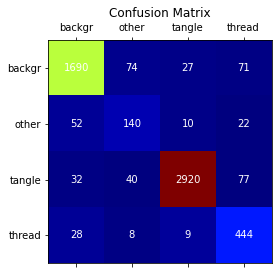

In [8]:
plt.matshow(cm, cmap=plt.cm.jet);
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(i, j, str(int(cm[i,j])), va='center', ha='center', color='white');
plt.title('Confusion Matrix');
tlab = [ "%.6s" % (x,) for x in config['class_to_idx'].keys()]
plt.xticks(range(num_classes), tlab);
plt.yticks(range(num_classes), tlab);

## Examine WildCat heat maps on random examples

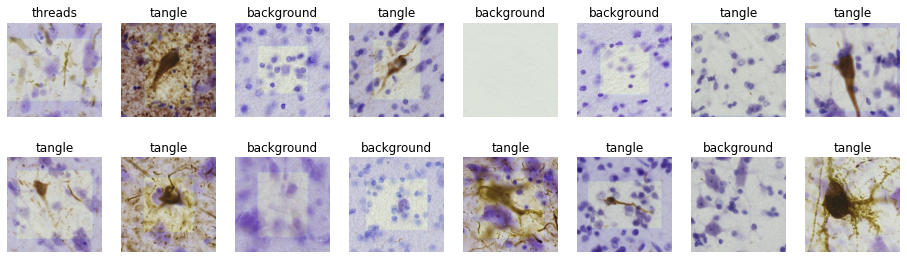

In [14]:
# Read a batch of data again
img,label=next(iter(dl))

# This time we drop the mask because we care about the activation maps over the whole patch
img_d = img[:,0:3,:,:].to(device)
plt.figure(figsize=(16,7))
util.show_patches_with_masks(img, label, cnames, 8, 0.1, 2)

In [15]:
# Do a manual forward run of the model
x_clas = model_ft.forward_to_classifier(img_d[:,0:3,:,:])
x_cpool = model_ft.spatial_pooling.class_wise(x_clas)
x_spool = model_ft.spatial_pooling.spatial(x_cpool)
x_cpool.shape

torch.Size([32, 4, 112, 112])

Plot below shows the response maps for the object class and background class, respectively

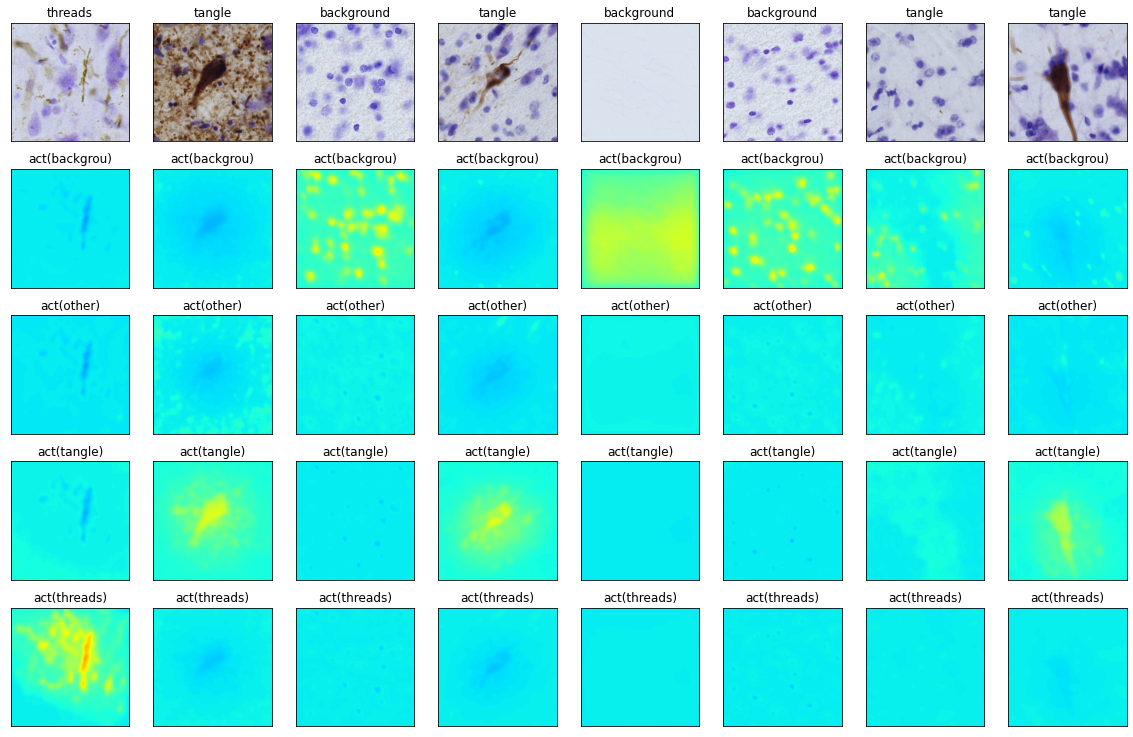

In [16]:
plt.figure(figsize=(20,3+2.5*num_classes))
ncol = min(8,batch_size)
for i in range(ncol):
    ax = plt.subplot(num_classes+1, ncol, i + 1)
    ax.imshow((img_d[i,:,:,:].cpu().detach().numpy().transpose(1,2,0) + 2.2) / 5.0)
    plt.title(list(config['class_to_idx'].keys())[label[i]])
    plt.xticks([]); plt.yticks([]);
for k in range(num_classes):
    for i in range(ncol):
        ax = plt.subplot(num_classes+1, ncol, ncol * (k+1) + i + 1)
        ax.imshow(x_cpool[i,k,:,:].cpu().detach().numpy(), vmin=-12, vmax=12, cmap=plt.get_cmap('jet'))
        plt.title('act(%.8s)' % (list(config['class_to_idx'].keys())[k]))
        plt.xticks([]); plt.yticks([]);
        

Repeat the same plot, but using softmax transformation

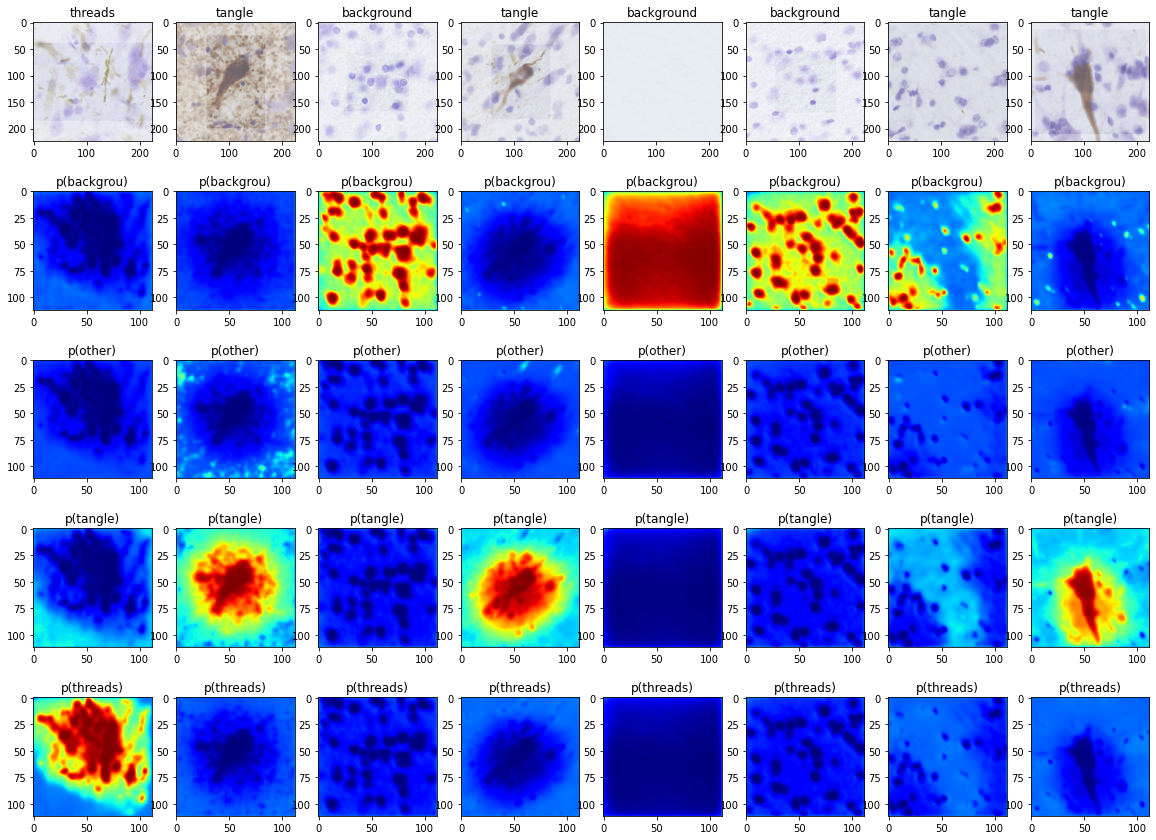

In [17]:
plt.figure(figsize=(20,3+3*num_classes))
x_softmax = scipy.special.softmax(x_cpool.cpu().detach().numpy(), axis=1) 
for i in range(ncol):
    plt.subplot(num_classes+1, ncol, i + 1)
    plt.imshow((img[i,:,:,:].detach().numpy().transpose(1,2,0) + 2.2) / 5.0)
    plt.title(list(config['class_to_idx'].keys())[label[i]])
for k in range(num_classes):
    for i in range(ncol):
        plt.subplot(num_classes+1, ncol, ncol * (k+1) + i + 1)
        plt.imshow(x_softmax[i,k,:,:], vmin=0, vmax=1, cmap=plt.get_cmap('jet'))
        plt.title('p(%.8s)' % (list(config['class_to_idx'].keys())[k]))

Load an arbitrary image patch from disk and apply similar processing

In [37]:
# fn_test='/data/pauly2/cndr_histo/scratch/test123/patch_18525_22128_5027_224_224.png'
# fn_test='/home/pauly2/cndr_histo/scratch/work/16781/patches/patch_16781_62703_78135_1395_1395.png'
# fn_test='/data/pauly2/cndr_histo/scratch/work/740/patches/patch_740_59274_121818_822_822.png'
# fn_test='/home/pauly2/cndr_histo/scratch/work/4908/patches/patch_4908_32734_142122_822_822.png'
# fn_test='/home/pauly2/cndr_histo/scratch/work/4644/patches/patch_4644_30599_90580_822_822.png'
# fn_test='/home/pauly2/cndr_histo/scratch/work/3871/patches/patch_3871_60894_84886_822_822.png'
fn_test = '/data/pauly2/wildcat/data/scratch/patch_at8_threads_7.png'
test_scale = 1
# test_scale = 2431/5045.

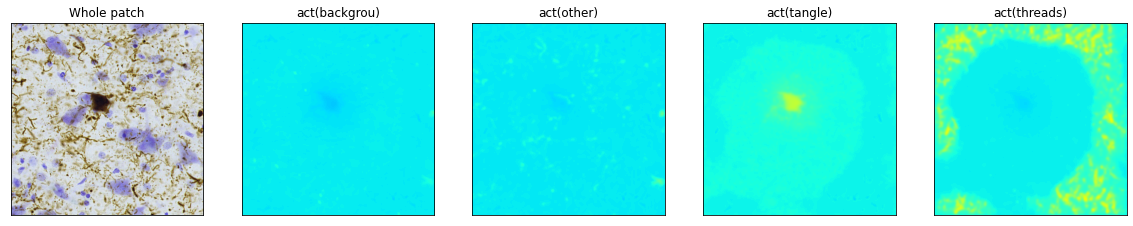

In [38]:
# Load image
i_test = Image.open(fn_test).convert('RGB')

# Define a new transform because the sample patch may have different pixel size
# and so needs to be scaled. On the other hand, we want to allow the patch to 
# have larger size, so we don't do center crop
dt_test = transforms.Compose([
        transforms.Resize(int(i_test.size[0] * test_scale)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Now try applying to the whole image instead
t_test_whole = dt_test(i_test).unsqueeze(0).to(device)
with torch.no_grad():    
    test_whole_clas = model_ft.forward_to_classifier(t_test_whole)
    test_whole_cpool = model_ft.spatial_pooling.class_wise(test_whole_clas)

# Make the plot
plt.figure(figsize=(20, 6))
plt.subplot(1, num_classes+1, 1)
plt.imshow((t_test_whole[0,:,:,:].cpu().detach().numpy().transpose(1,2,0) + 2.2) / 5.0);
plt.title('Whole patch');
plt.xticks([]); plt.yticks([]); 
for k in range(num_classes):
    plt.subplot(1, num_classes+1, 2+k)
    plt.imshow(test_whole_cpool[0,k,:,:].cpu().detach().numpy(), vmin=-12, vmax=12, cmap=plt.get_cmap('jet'))
    plt.title('act(%.8s)' % (list(config['class_to_idx'].keys())[k]))
    plt.xticks([]); plt.yticks([]); 
# plt.colorbar()

In [39]:
# Apply unfolding to break up the patch into small overlapping patches
t_test_unfold = dt_test(i_test).unfold(2, input_size, input_size//2).unfold(1, input_size, input_size//2).reshape([3,-1,224,224]).transpose(0,1)

# Select a random subset of patches for display
ncol = min(8,t_test_unfold.shape[0])
idx_test = np.arange(t_test_unfold.shape[0])
np.random.shuffle(idx_test)
idx_test = idx_test[:ncol]
t_test_batch = t_test_unfold[idx_test,:,:,:]

t_test = t_test_batch.to(device)

test_x_clas = model_ft.forward_to_classifier(t_test)
test_x_cpool = model_ft.spatial_pooling.class_wise(test_x_clas)
test_x_spool = model_ft.spatial_pooling.spatial(test_x_cpool)

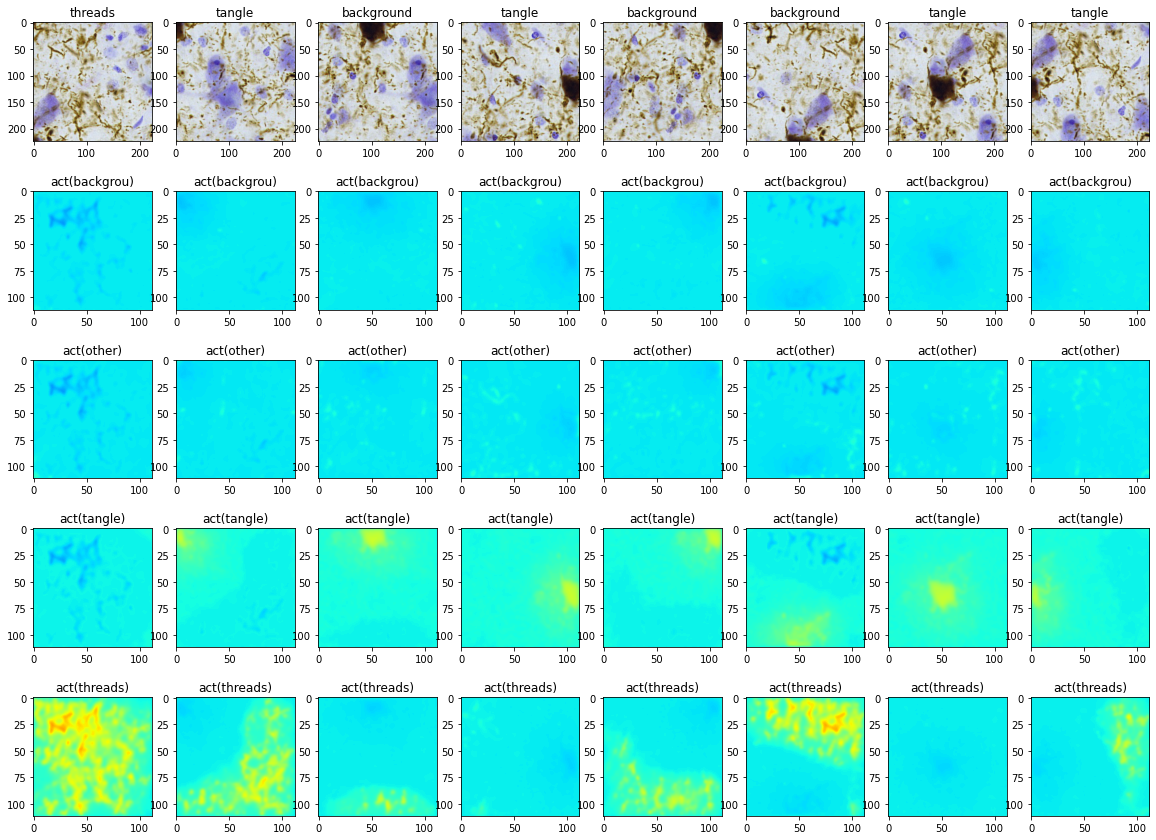

In [40]:
plt.figure(figsize=(20,3+3*num_classes))
# ncol = min(8,batch_size)
for i in range(ncol):
    plt.subplot(num_classes+1, ncol, i + 1)
    plt.imshow((t_test[i,:,:,:].cpu().detach().numpy().transpose(1,2,0) + 2.2) / 5.0)
    plt.title(list(config['class_to_idx'].keys())[label[i]])
for k in range(num_classes):
    for i in range(ncol):
        plt.subplot(num_classes+1, ncol, ncol * (k+1) + i + 1)
        plt.imshow(test_x_cpool[i,k,:,:].cpu().detach().numpy(), vmin=-12, vmax=12, cmap=plt.get_cmap('jet'))
        plt.title('act(%.8s)' % (list(config['class_to_idx'].keys())[k]))
        

In [41]:
stride=56
padx, pady = int((np.ceil(396/stride) * stride - 396) / 2), int((np.ceil(396/stride) * stride - 396) / 2)

In [42]:
# Pad the image to have the size multiple of 112


In [42]:
x=dt_test(i_test).unsqueeze(0).to(device)
x_padded = torch.nn.functional.pad(x, (padx, padx, pady, pady))
x_batched=torch.nn.functional.unfold(x_padded, 224, stride=stride)[0].transpose(0,1).view(-1,3,224,224)
y = model_ft.forward_to_classifier(x_batched)
y = model_ft.spatial_pooling.class_wise(y)
y.shape

torch.Size([49, 4, 112, 112])

In [43]:
y.view(y.shape[0],-1).transpose(1,0).unsqueeze(0).shape

torch.Size([1, 50176, 49])

In [44]:
z=torch.nn.functional.fold(y.view(y.shape[0],-1).transpose(1,0).unsqueeze(0),(x_padded.shape[2]//2,x_padded.shape[3]//2),112,stride=stride//2)

In [45]:
znorm=torch.nn.functional.fold(1.0 + 0.0*y.view(y.shape[0],-1).transpose(1,0).unsqueeze(0),(x_padded.shape[2]//2,x_padded.shape[3]//2),112,stride=stride//2)
z = z / znorm

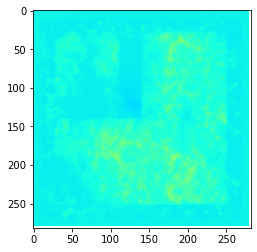

In [46]:
plt.imshow(z[0,3,:,:].cpu().detach().numpy(), vmin=-12, vmax=12, cmap=plt.get_cmap('jet'))

## Experiment with contrastive loss

In [19]:
# Run model on input patches and compute softmax
z=model_bb.wildcat_model.forward_to_classifier(img_d[:,:3,:,:])
z=torch.nn.functional.softmax(z, 1)

In [37]:
# Compute mean RGB vectors
rgb = torch.nn.functional.interpolate(img_d[:,:3,:,:], scale_factor=0.5, mode='bilinear',align_corners=False)

In [38]:
(rgb * z).sum(axis=3)

RuntimeError: The size of tensor a (3) must match the size of tensor b (16) at non-singleton dimension 1

In [39]:
(rgb * z).shape

RuntimeError: The size of tensor a (3) must match the size of tensor b (16) at non-singleton dimension 1

In [48]:
(z[:,0:1,:,:] * rgb).sum(axis=(2,3)) / (z[:,0:1,:,:]).sum(axis=(2,3))

tensor([[ 1.2588,  1.2960,  1.9340],
        [ 1.8196,  1.8434,  2.0656],
        [ 1.3448,  1.3575,  1.9463],
        [ 0.3624, -0.0914,  1.6737],
        [ 0.9132,  0.6045,  0.4695],
        [ 1.5534,  1.5471,  1.9719],
        [ 1.8802,  1.9338,  2.0344],
        [ 1.0744,  0.9447,  1.4511],
        [ 1.4812,  1.3663,  1.4760],
        [ 0.9631,  0.9376,  1.3232],
        [ 0.7019,  0.2969,  0.0604],
        [ 1.8160,  1.8590,  2.1542],
        [ 1.4149,  1.3842,  1.8480],
        [ 1.6189,  1.7092,  2.0816],
        [ 2.0656,  2.2421,  2.4523],
        [ 1.3617,  1.1601,  0.5590],
        [ 1.8158,  1.8627,  2.2128],
        [ 1.2781,  1.1990,  1.6778],
        [ 1.4809,  1.4138,  1.4297],
        [ 1.4753,  1.4446,  1.9669]], device='cuda:0', grad_fn=<DivBackward0>)

In [47]:
(z[:,4:5,:,:] * rgb).sum(axis=(2,3)) / (z[:,4:5,:,:]).sum(axis=(2,3))

tensor([[ 1.3920,  1.4452,  2.0023],
        [ 1.8180,  1.8408,  2.0527],
        [ 1.3454,  1.3576,  1.9454],
        [ 0.3623, -0.0915,  1.6714],
        [ 0.8511,  0.5170,  0.3675],
        [ 1.5448,  1.5352,  1.9631],
        [ 1.8734,  1.9241,  2.0183],
        [ 1.0424,  0.9061,  1.3752],
        [ 1.4537,  1.3299,  1.4107],
        [ 1.1782,  1.1681,  1.4123],
        [ 0.6102,  0.1829, -0.0528],
        [ 1.8094,  1.8490,  2.1413],
        [ 1.3704,  1.3272,  1.8111],
        [ 1.7754,  1.8707,  2.2277],
        [ 2.0660,  2.2424,  2.4525],
        [ 1.2532,  1.0257,  0.4016],
        [ 1.8120,  1.8572,  2.2040],
        [ 1.2668,  1.1840,  1.6555],
        [ 1.4658,  1.3930,  1.3972],
        [ 1.4635,  1.4293,  1.9308]], device='cuda:0', grad_fn=<DivBackward0>)

In [184]:
# Compute the cluster means
c_means = torch.einsum('bkij,bcij->bkc',z,rgb) / torch.einsum('bkij->bk',z).unsqueeze(-1)

# Squared deviations from the means at each pixel
c_sqdev = torch.sum((rgb.unsqueeze(1) - c_means.unsqueeze(-1).unsqueeze(-1))**2, axis=2)

# Average cluster-to-center squared distance matrix (entry b,p,k is the average distance
# from cluster p to center k)
c_dmat = torch.einsum('bkij,bpij->bkp',z,c_sqdev) / torch.einsum('bkij->bk',z).unsqueeze(-1)

# Matrix of penalties
c_exp_dmat_diag = torch.exp(torch.diagonal(c_dmat,dim1=1,dim2=2))
c_pmat = -torch.log(c_exp_dmat_diag / (torch.sum(torch.exp(c_dmat),axis=1) - c_exp_dmat_diag))

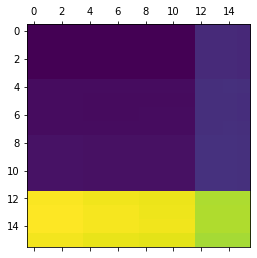

In [185]:
plt.matshow(c_dmat[6,:,:].detach().cpu().numpy())

Test the computation. Here k is the cluster mean we want to test, p is the cluster from which we want to measure the distance to the mean, and b is the minibatch index

In [186]:
b,k,p=0,2,7
test_mean_k = torch.sum(rgb[b,:] * z[b,k,:].unsqueeze(0),axis=(1,2)) / torch.sum(z[b,k,:])
test_mean_k, c_means[b,k,:]

(tensor([1.2587, 1.2958, 1.9339], device='cuda:0', grad_fn=<DivBackward0>),
 tensor([1.2587, 1.2958, 1.9339], device='cuda:0', grad_fn=<SliceBackward>))

Subtract the mean of cluster k from all the RGB values and take squared difference

In [187]:
test_pix_dist_to_mean_k = torch.sum((rgb[b,:,:,:] - test_mean_k.unsqueeze(-1).unsqueeze(-1))**2, axis=0)
test_cluster_p_dist_to_mean_k = torch.sum(test_pix_dist_to_mean_k * z[b,p,:]) / torch.sum(z[b,p,:])
test_cluster_p_dist_to_mean_k, c_dmat[b,p,k]

(tensor(1.1305, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.1305, device='cuda:0', grad_fn=<SelectBackward>))

Finally test the penalty computation

In [188]:
test_penalty = -torch.log(torch.exp(c_dmat[b,k,k]) / (torch.sum(torch.exp(c_dmat[b,:,k])) - torch.exp(c_dmat[b,k,k])))
test_penalty, c_pmat[b,k]

(tensor(2.3876, device='cuda:0', grad_fn=<NegBackward>),
 tensor(2.3876, device='cuda:0', grad_fn=<SelectBackward>))

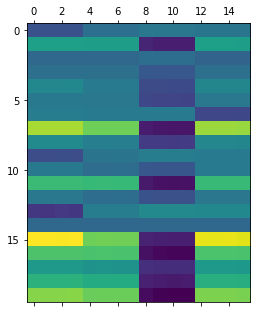

In [189]:
plt.matshow(c_pmat.detach().cpu().numpy())